In [1]:
##Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 350)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)
sns.set(style='darkgrid')
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker


# import all libraries and dependencies for machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer


import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats
from scipy.stats import norm, kurtosis, skew

# Import specific libraries
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices

pd.set_option('expand_frame_repr', False)

In [2]:
#Loading datasets
%store -r all_data
%store -r y_train
%store -r cols

In [3]:
all_data.head()
all_data[cols]

,LotFrontage,Street,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,PavedDrive,OpenPorchSF,EnclosedPorch,Fence,MiscVal,YrSold,TotalPoints,TotalExtraPoints,GarageArea_x_Car,ConstructArea,Garage_Newest,LotAreaMultSlope,TotBathrooms,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RM,Alley_NA,Alley_Pave,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Twnhs,HouseStyle_15Fin,HouseStyle_15Unf,HouseStyle_25Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_TarGrv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_WdSdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkCmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_WdSdng,Exterior2nd_WdShng,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_BrkTil,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Othr,MiscFeature_Pool,MiscFeature_Shed,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_11,MoSold_12,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,Remod,IsNew
0,65.0000,1,4,3,5,8,8,196.0000,4,3,4,3,1,6,1,5,1,1,0,1,1,3,1,4,8,7,0,8.0000,2,3,61,0,1,0,3,91,9,1096.0000,3371.0000,0,25350,3.5000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,80.0000,1,4,3,8,35,35,0.0000,3,3,4,3,4,5,1,5,1,0,1,1,0,3,1,3,6,7,1,35.0000,2,3,0,0,1,0,4,84,11,920.0000,3282.0000,0,28800,2.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,68.0000,1,3,3,5,10,9,162.0000,4,3,4,3,2,6,1,5,1,1,0,1,1,3,1,4,6,7,1,10.0000,2,3,42,0,1,0,3,95,12,1216.0000,3518.0000,0,33750,3.5000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [4]:
##El método de más arriba tira error de sintaxis con el feature 2ndFlrSF porque empieza con 2 (parece),así que rename

all_data.rename(columns={'2ndFlrSF':'SndFlrSF'}, inplace=True)

In [5]:
cols

Index(['LotFrontage', 'Street', 'LotShape', 'LandSlope', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'Remod', 'IsNew'],
      dtype='object', length=188)

In [6]:
###treatment of skewed features

#Seleccionamos los numeric features only (usamos cols porque esos son los feats que quedaron)
numeric_features = all_data.loc[:, list(cols)].dtypes[(all_data.dtypes != "category") & (all_data.dtypes != "uint8")].index

# #Calculamos los skewes y los ordenamos...
skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending =False)

#Seleccionamos los que tengan un abs(skew) >0.7
skewed_max = pd.DataFrame({"Skew": skewed_features})
skewed_max  = skewed_max[abs(skewed_max["Skew"]) > 0.7]
skewed_max.dropna()

#Aplicamos ahora la BoxCox transformation
l_opt = {}
for f in skewed_max.index:
    all_data[f], l_opt[f] = boxcox((all_data[f] + 1))
    
#Checking the results...

skewed_features_2 = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending =False)
sk_2 = pd.DataFrame({"Skew_before":skewed_features, "Skew_after": skewed_features_2})
sk_2 = sk_2[abs(sk_2["Skew_before"]) > 0.7].sort_values(by = "Skew_before", ascending = False)
sk_2

,Skew_before,Skew_after
MiscVal,21.7498,4.7723
KitchenAbvGr,4.3485,-2.0594
LotAreaMultSlope,3.4938,0.1363
BsmtFinType2,3.1472,-0.4339
MasVnrArea,2.6218,0.4568
OpenPorchSF,2.5290,-0.0250
Fence,1.7514,1.5327
GarageArea_x_Car,1.3543,-0.1323
ExterCond,1.3130,-0.0363
LotFrontage,1.2307,0.1710


In [9]:
"""Casi todos los features quedaron con un skew aceptable y cercano al normal, aunque los dos primeros
todavía se ven flojos. Una análisis útil para ver cómo quedan y si aúns e pueden abordar con ajustes discretos
es el análisis gráfico: QQPlot y Density Plot"""

'Casi todos los features quedaron con un skew aceptable y cercano al normal, aunque los dos primeros\ntodavía se ven flojos. Una análisis útil para ver cómo quedan y si aúns e pueden abordar con ajustes discretos\nes el análisis gráfico: QQPlot y Density Plot'

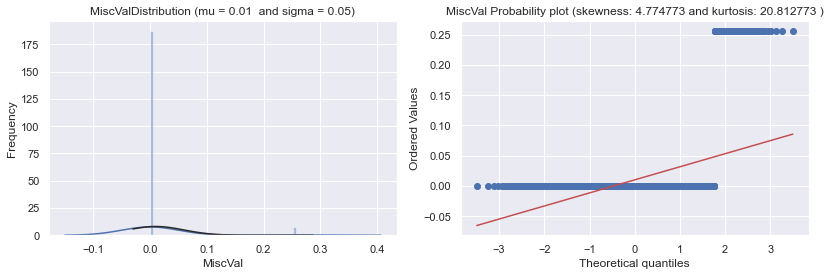

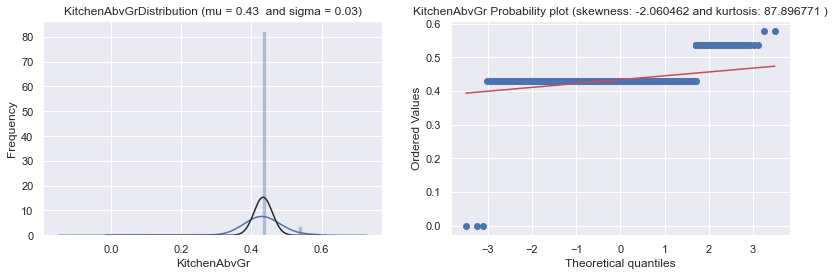

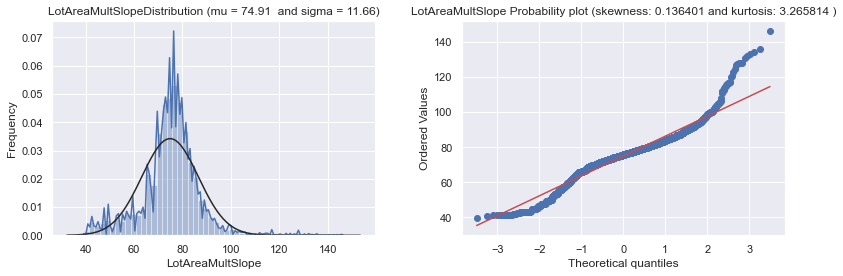

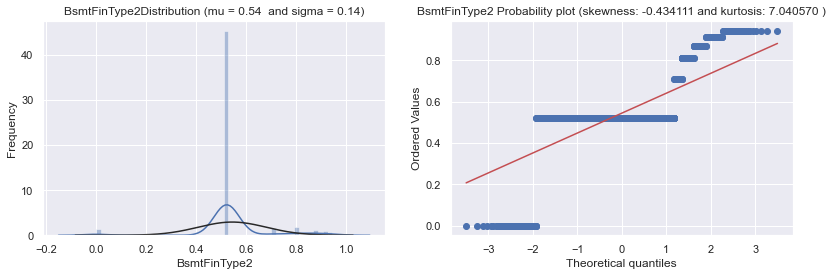

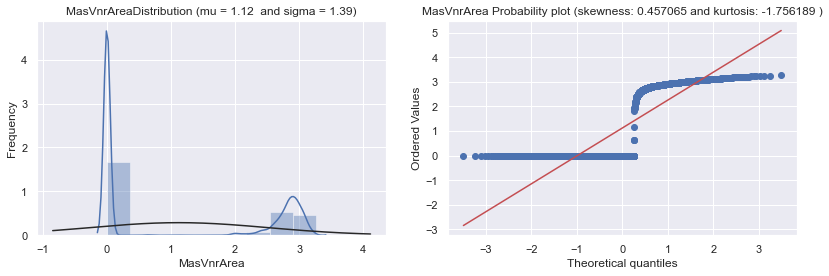

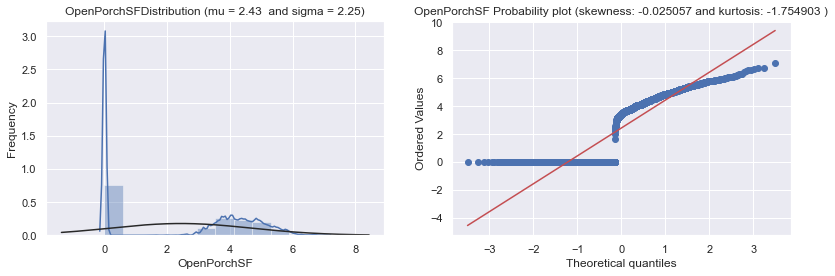

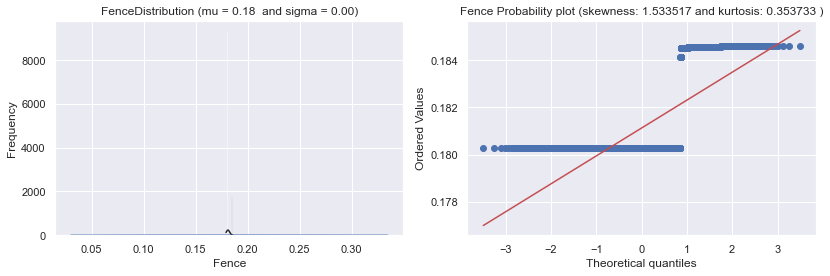

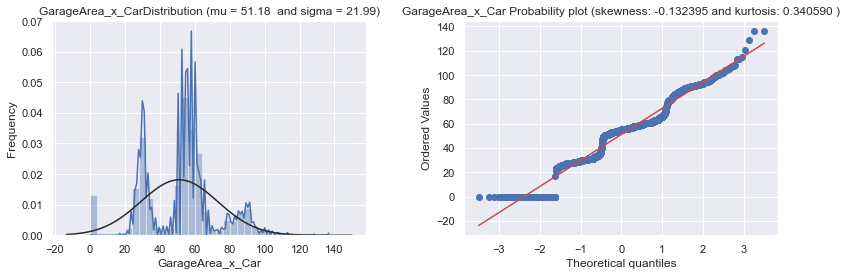

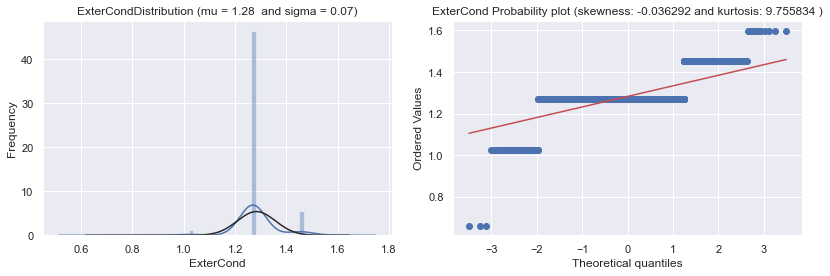

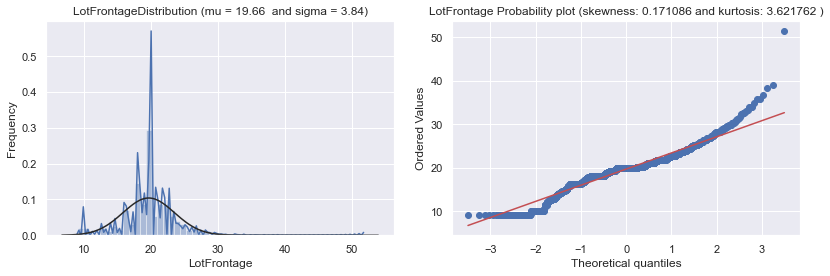

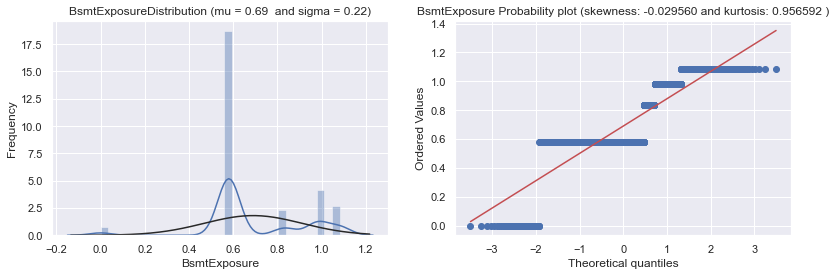

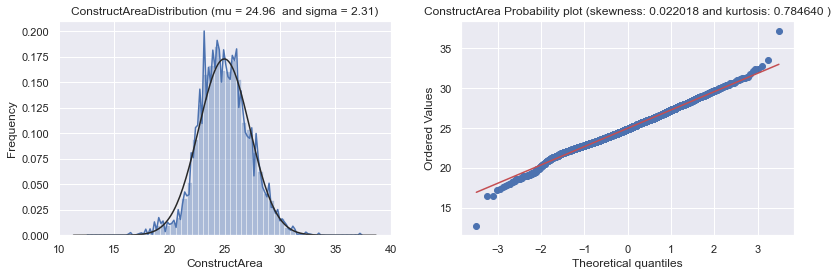

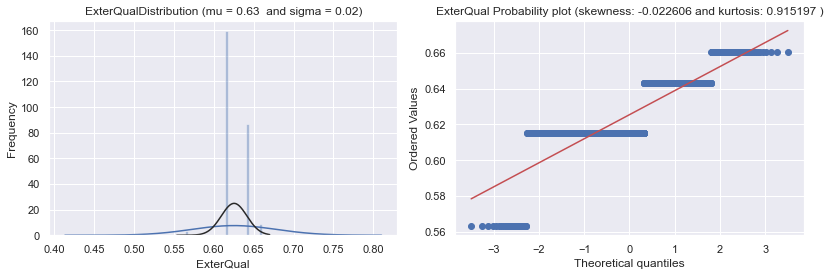

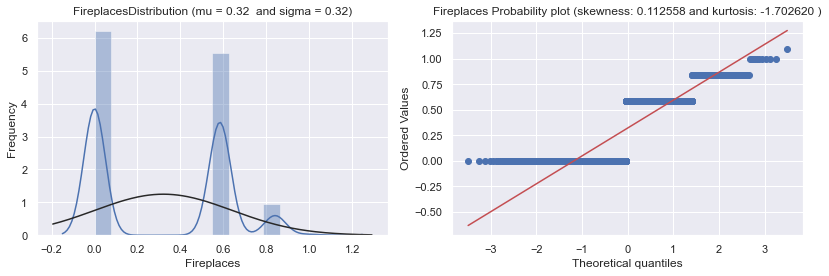

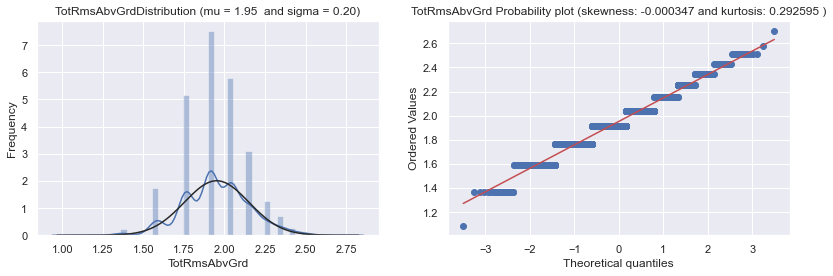

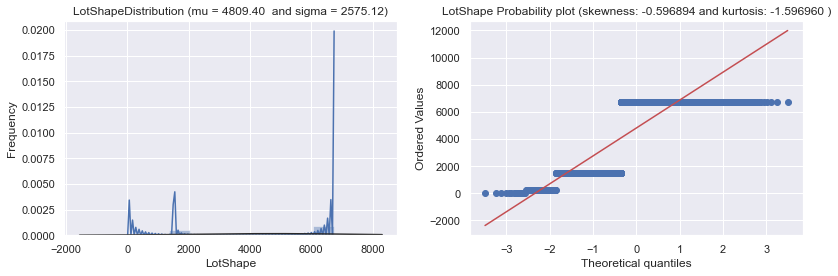

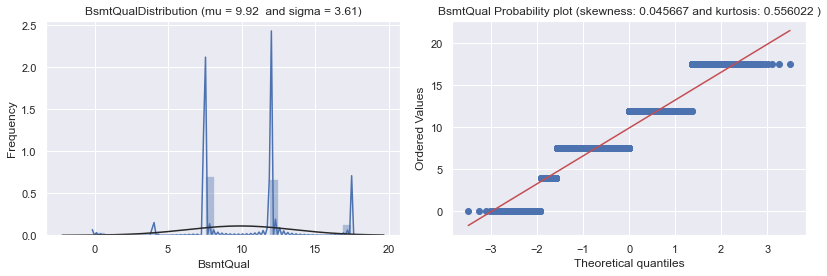

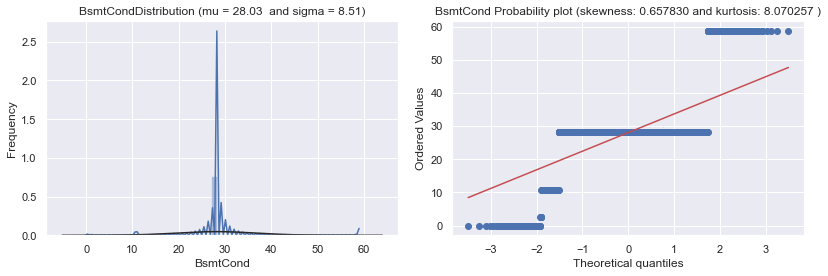

In [34]:
##EVALUACION GRÁFICA DE LOS FEATURES TRANSFORMADOS

"""Método para plotear los features"""

def QQ_plot(data, feature_name):
    #Setting the canvas
    fig = plt.figure(figsize = (12,4))
    
    #Fit the parameters (estimates the parameters of the function)
    (mu, sigma) = norm.fit(data)
    
    #Plots the kernel density plot KD for the feature
    fig1 = fig.add_subplot(121) # una fila con 2 plots, empezando con el 1
    sns.distplot(data, fit = norm,  hist=True, kde_kws={'bw':0.05})
     

#     sns.distplot(data , fit = norm)
    fig1.set_title(feature_name + "Distribution (mu = {:.2f}  and sigma = {:.2f})".format(mu,sigma), loc = "center")
    fig1.set_xlabel(feature_name)
    fig1.set_ylabel("Frequency")
    
    #Plots de qq-plot
    fig2 = fig.add_subplot(122) # segundo plot
    res = probplot(data, plot = fig2)
    fig2.set_title(feature_name + " Probability plot (skewness: {:.6f} and kurtosis: {:.6f} )".format(data.skew(), data.kurt()),
                 loc = "center")
    plt.tight_layout()
    
    plt.show()
    
for f in skewed_max.index:
    QQ_plot(all_data[f], f)

In [35]:
"""Puede verse que KitchenAbvGr y MiscVal siguen mostrando un alto skewness. Las otras variables muestran mejorías
importantes en sus skewness y en general también en sus kurtosis"""

'Puede verse que KitchenAbvGr y MiscVal siguen mostrando un alto skewness. Las otras variables muestran mejorías\nimportantes en sus skewness y en general también en sus kurtosis'